In [1]:
import pymc as pm
import pytensor.tensor as pt
import arviz as az

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3

# Data Acquisition



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/"  #Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

n_jobs = 1

league_data = pd.read_sql("SELECT * FROM League;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

* Extract premier league matches





In [4]:
pl_match_data = match_data[match_data['country_id'] == 1729]
pl_match_data = pl_match_data.merge(team_data,left_on = 'home_team_api_id',right_on = 'team_api_id')
pl_match_data = pl_match_data[['season','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','team_long_name']]
pl_match_data = pl_match_data.rename(columns={'team_long_name': 'home_team'})

pl_match_data = pl_match_data.merge(team_data,left_on = 'away_team_api_id',right_on = 'team_api_id')
pl_match_data = pl_match_data[['season','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','home_team', 'team_long_name']]
pl_match_data = pl_match_data.rename(columns={'team_long_name': 'away_team'})
pl_match_data

,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team,away_team
0,2008/2009,10260,10261,1,1,Manchester United,Newcastle United
1,2010/2011,10260,10261,3,0,Manchester United,Newcastle United
2,2011/2012,10260,10261,1,1,Manchester United,Newcastle United
3,2012/2013,10260,10261,4,3,Manchester United,Newcastle United
4,2013/2014,10260,10261,0,1,Manchester United,Newcastle United
...,...,...,...,...,...,...,...
3035,2013/2014,8344,10260,2,2,Cardiff City,Manchester United
3036,2014/2015,8197,10260,5,3,Leicester City,Manchester United
3037,2015/2016,8197,10260,1,1,Leicester City,Manchester United
3038,2015/2016,8678,10260,2,1,Bournemouth,Manchester United




* Remove latest year from the dataset to use for testing
* Remove unseen teams from test set



In [5]:
pl_match_data_train = pl_match_data[pl_match_data['season'] != '2015/2016']
pl_match_data_test = pl_match_data[pl_match_data['season'] == '2015/2016']

for team in pl_match_data_test['home_team'].unique():

  if team not in pl_match_data_train['home_team'].unique():
    pl_match_data_test = pl_match_data_test[pl_match_data_test['home_team'] != team]
    pl_match_data_test = pl_match_data_test[pl_match_data_test['away_team'] != team]


In [6]:
plt.rcParams["figure.constrained_layout.use"] = True

home_idx, teams = pd.factorize(pl_match_data_train["home_team"], sort=True)
away_idx, _ = pd.factorize(pl_match_data_train["away_team"], sort=True)
home_idx_test = pl_match_data_test['home_team'].apply(lambda x: np.where(teams == x)[0][0]).values
away_idx_test = pl_match_data_test['away_team'].apply(lambda x: np.where(teams == x)[0][0]).values

coords = {"team": teams, 'match':np.arange(len(pl_match_data_train))}

# Initial Model

In [7]:
def create_basic_model(data):

  with pm.Model(coords=coords) as model:

    model.add_coord("match", np.arange(len(data)), mutable=True)
    home_team = pm.MutableData("home_team", home_idx, dims="match")
    away_team = pm.MutableData("away_team", away_idx, dims="match")

    offset = pm.Normal('offset',0.25,0.25)
    home = pm.Normal('home',0.25,0.25)

    att_star = pm.Normal('att_star', mu = 0, sigma = 0.5,dims = 'team')
    def_star = pm.Normal('def_star', mu = 0, sigma = 0.5, dims = 'team')

    attack = pm.Deterministic("attack", att_star - pt.mean(att_star), dims="team")
    defence = pm.Deterministic("defence", def_star - pt.mean(def_star), dims="team")

    home_theta = pt.exp(offset + home + attack[home_team] - defence[away_team])
    away_theta = pt.exp(offset + attack[away_team] - defence[home_team])

    home_goals = pm.Poisson(
        "home_goals",
        mu=home_theta,
        observed=data["home_team_goal"].values,
        dims = 'match'
    )
    away_goals = pm.Poisson(
        "away_goals",
        mu=away_theta,
        observed=data["away_team_goal"].values,
        dims = 'match'

    )
    trace = pm.sample(2000,tune = 2000, chains = 4, random_seed = 64)

  return trace, model

In [8]:
basic_trace, basic_model = create_basic_model(pl_match_data_train)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


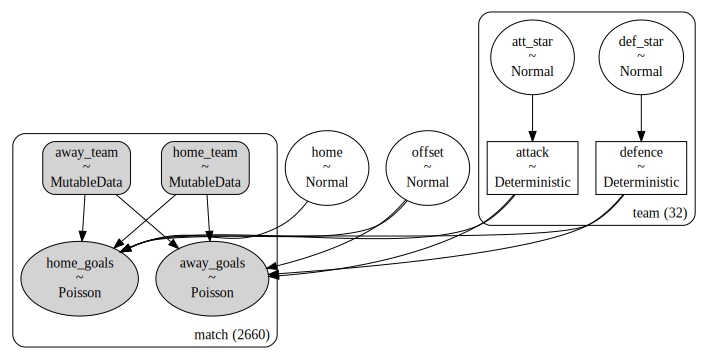

In [9]:
pm.model_to_graphviz(basic_model)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


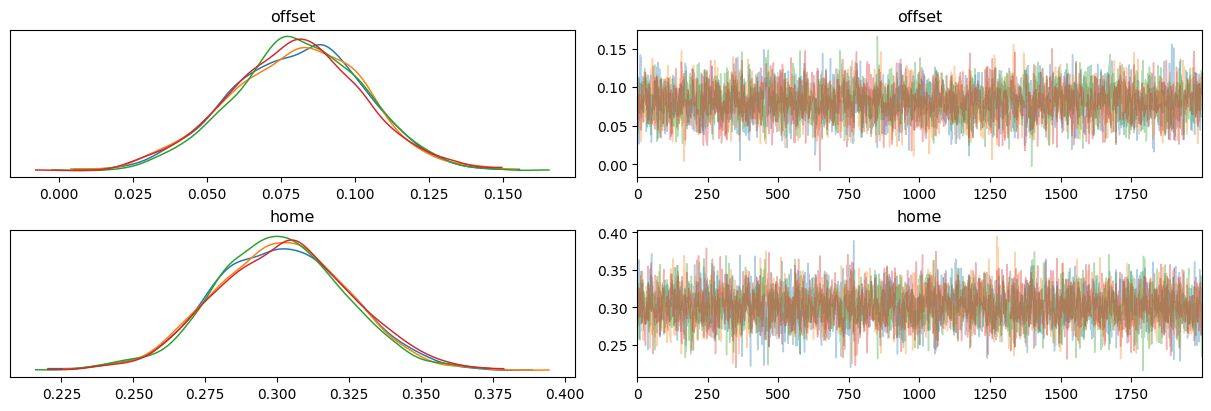

In [10]:
az.plot_trace(basic_trace,var_names= ['offset','home'], compact=False);

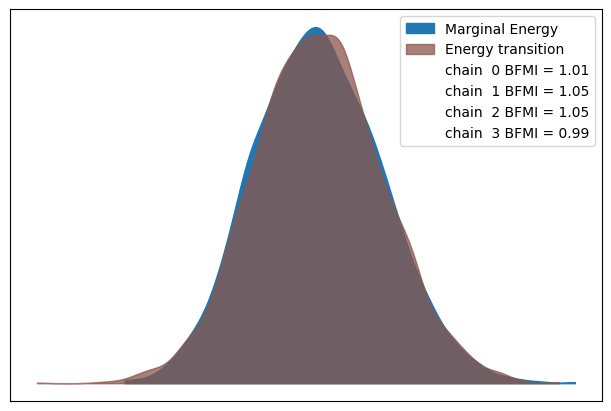

In [11]:
az.plot_energy(basic_trace, figsize=(6, 4));

In [12]:
def plot_team_values(trace):

    trace_hdi = az.hdi(trace)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    indices = trace.posterior['attack'].median(dim=("chain", "draw"))
    indices2 = trace.posterior['attack'].median(dim=("chain", "draw")).argsort()

    for i, mode in enumerate(['attack', 'defence']):
        color = "C0" if mode == "defence" else "darkorange"
        ax[i].scatter(trace.posterior[mode].median(dim=("chain", "draw")).sortby(indices), teams[indices2], color=color, alpha=1, s=100)
        ax[i].hlines(
            teams,
            trace_hdi[mode].sel({"hdi": "lower"}),
            trace_hdi[mode].sel({"hdi": "higher"}),
            alpha=0.6,
            lw=5,
            color=color,
        )
        if i == 0:
            ax[i].set_ylabel('teams')
        else:
            ax[i].tick_params(labelleft=False)  # Hide y-axis ticks
            ax[i].set_ylabel('')  # Remove y-axis label

        ax[i].set_xlabel("Posterior " + mode + " Strength")
        ax[i].set_title("HDI of Team-wise " + mode + " Strength")
        ax[i].set_xlim([-0.85, 0.6])

    plt.tight_layout()

<ipython-input-12-4ef84b1019f1>:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


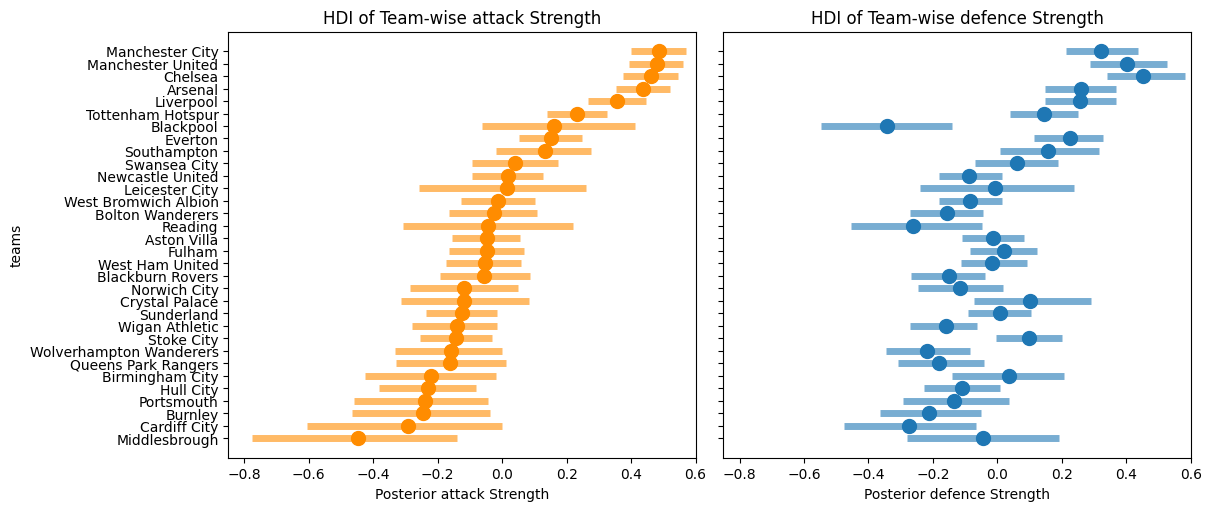

In [13]:
plot_team_values(basic_trace)

In [14]:
basic_pcc = pm.sample_posterior_predictive(basic_trace, model = basic_model)

In [15]:
def plot_ppc(pcc):

  az.plot_ppc(pcc, kind='cumulative', num_pp_samples=20)

  fig = plt.gcf()
  axes = fig.get_axes()

  for ax in axes:
      ax.set_xlim([-0.5, 6])

  axes[0].set_xlabel('Home_Goals')
  axes[0].set_ylabel('ECDF')
  axes[1].set_xlabel('Away_Goals')
  axes[1].set_ylabel('ECDF')
  fig.suptitle('Posterior Predictive Check (Cumulative)')

  plt.show()

In [16]:
#plot_ppc(basic_pcc)



*   Potentially overpredicting low scores and underpredicting high scores for home teams
*   Could be due to 'game effects': The number of goals one team scores likely has an impact on the goals the other team scores



In [17]:
def plot_error(pcc):

  post_df = pl_match_data_train.copy()

  predictions = pcc.posterior_predictive['home_goals'].values
  predictions_home = np.mean(predictions, axis = (0,1))

  predictions = pcc.posterior_predictive['away_goals'].values
  predictions_away = np.mean(predictions, axis = (0,1))

  post_df['away_team_goal_pred'] = predictions_away
  post_df['home_team_goal_pred'] = predictions_home

  post_df['away_error'] = post_df['away_team_goal_pred'] - post_df['away_team_goal']

  away_error_df = post_df.groupby('home_team_goal')['away_error'].agg(['mean','count']).reset_index().iloc[0:8]

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))
  sns.barplot(data = away_error_df, x = 'home_team_goal',y = 'mean', ax=axs[0])
  sns.barplot(data = away_error_df, x = 'home_team_goal',y = 'count', ax=axs[1])

  axs[0].set_ylabel('Away goals error (Predictive - Actual)')
  for i in range(2):
    axs[i].set_xlabel('Home goals')

  plt.show()

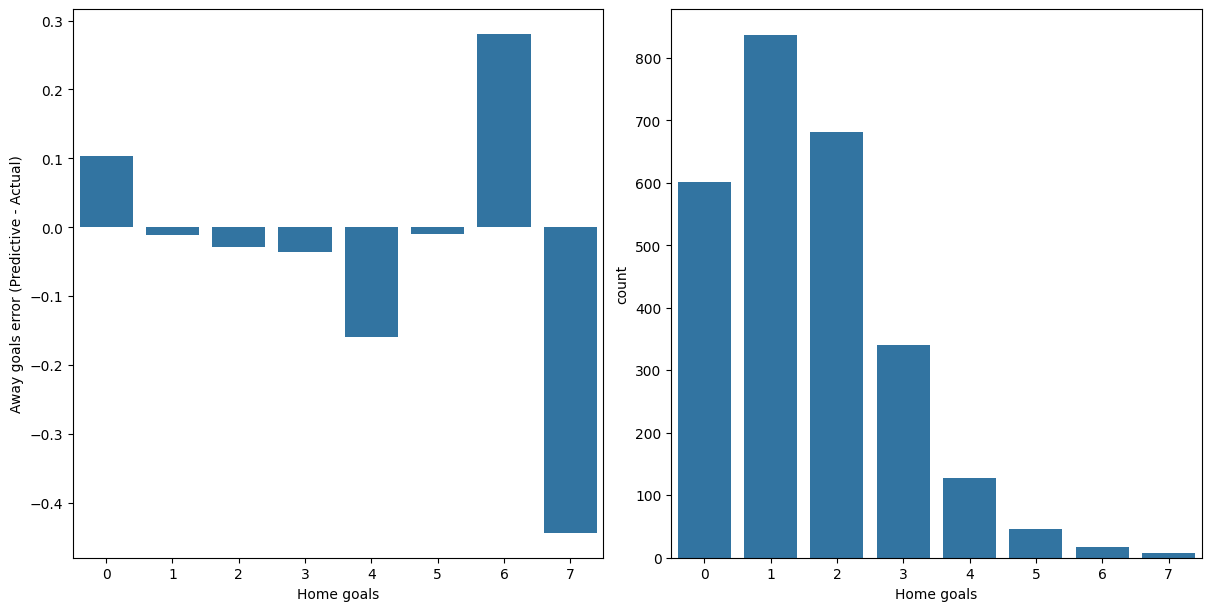

In [18]:
plot_error(basic_pcc)



*   When the home team scores 0 goals, we tend to overpredict the goals of the away team
*   As the number of goals increases we see this reverse, although the trend is not linear
*  This trend continues until the home team scores 5 goals. This could be due to small sample sizes, or the other team giving up.






*   Predictions using train and test data

In [19]:
def prob_based_acc(**kwargs):
  a, b, c, d, e = list(kwargs.values())[:5]
  if a > b:
    return c
  elif b > a:
    return d
  return e

def model_based_acc(**kwargs):
  a, b, c, d, e, f = list(kwargs.values())[:6]

  if f == np.max([c,d,e]):
    return 1
  else:
    return 0

def predictions(data, trace, model, home_idx, away_idx):

  with model:

    pm.set_data({"home_team": home_idx, "away_team": away_idx}, coords = {"team": teams, 'match':np.arange(len(data))})
    pred = pm.sample_posterior_predictive(trace, var_names=["home_goals", "away_goals"], predictions = 'True').predictions

    home_wins = (pred['home_goals'] > pred['away_goals']).values.mean((0,1))
    away_wins = (pred['home_goals'] < pred['away_goals']).values.mean((0,1))
    draw = (pred['home_goals'] == pred['away_goals']).values.mean((0,1))

    df_pred = pd.DataFrame({'Home_goals' : data['home_team_goal'], 'Away_goals' : data['away_team_goal'] ,'Home_win_pred': home_wins, 'Away_win_pred': away_wins, 'Draw_pred': draw})

    df_pred['prob_based_acc'] = df_pred.apply(lambda row: prob_based_acc(**row), axis=1)
    df_pred['model_based_acc'] = df_pred.apply(lambda row: model_based_acc(**row), axis=1)

    return df_pred


In [20]:
train_acc_df = predictions(pl_match_data_train, basic_trace, basic_model, home_idx, away_idx)
train_acc_df.iloc[:,-2:].mean()

prob_based_acc     0.424363
model_based_acc    0.536090
dtype: float64

In [21]:
test_acc_df = predictions(pl_match_data_test, basic_trace, basic_model, home_idx_test, away_idx_test)
test_acc_df.iloc[:,-2:].mean()

prob_based_acc     0.375995
model_based_acc    0.434641
dtype: float64



*   Suffers from severe fall in accuracy on the test data
*   Likely due to long term changes in team quality along with unexpected short term changes in the 15/16 season.



# 2nd Model

* For the 2nd model, I will take into account 'game effects'.
* As explained earlier, the number of goals scored by 1 team is likely to have an effect on the goals scored by the opposition. We can create a hierarchical model using 'home goals' as input into 'away goals'.
* We will assume a linear relationship between the number of goals scored by the home team and increase in attacking nature of away team.




In [22]:
def create_model2(data):

  with pm.Model(coords=coords) as model:

    model.add_coord("match", np.arange(len(data)), mutable=True)
    home_team = pm.MutableData("home_team", home_idx, dims="match")
    away_team = pm.MutableData("away_team", away_idx, dims="match")

    offset = pm.Normal('offset',0.25,0.25)
    home = pm.Normal('home',0.25,0.25)
    score_effects = pm.Normal('score_effects',0,0.25)

    att_star = pm.Normal('att_star', mu = 0, sigma = 0.5,dims = 'team')
    def_star = pm.Normal('def_star', mu = 0, sigma = 0.5, dims = 'team')

    attack = pm.Deterministic("attack", att_star - pt.mean(att_star), dims="team")
    defence = pm.Deterministic("defence", def_star - pt.mean(def_star), dims="team")

    home_theta = pt.exp(offset + home + attack[home_team] - defence[away_team])

    home_goals = pm.Poisson(
        "home_goals",
        mu=home_theta,
        observed=data["home_team_goal"].values,
        dims = 'match'
    )

    away_theta = pt.exp(offset + attack[away_team] - defence[home_team] + home_goals * score_effects)

    away_goals = pm.Poisson(
        "away_goals",
        mu=away_theta,
        observed=data["away_team_goal"].values,
        dims = 'match'

    )
    trace = pm.sample(2000, tune = 2000, chains = 4, random_seed = 64)

  return trace, model

In [23]:
trace2, model2 = create_model2(pl_match_data_train)

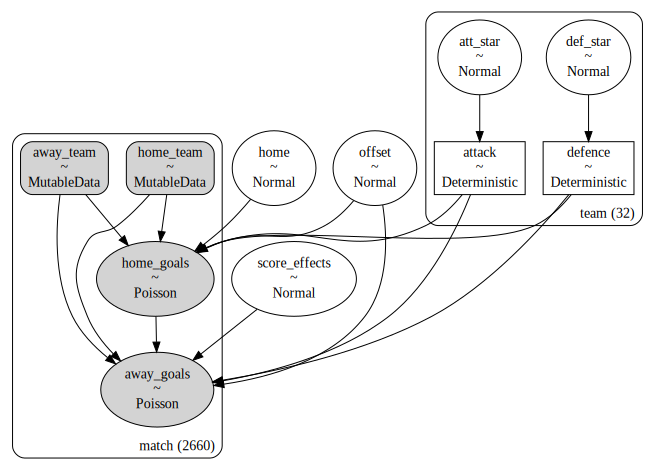

In [24]:
pm.model_to_graphviz(model2)

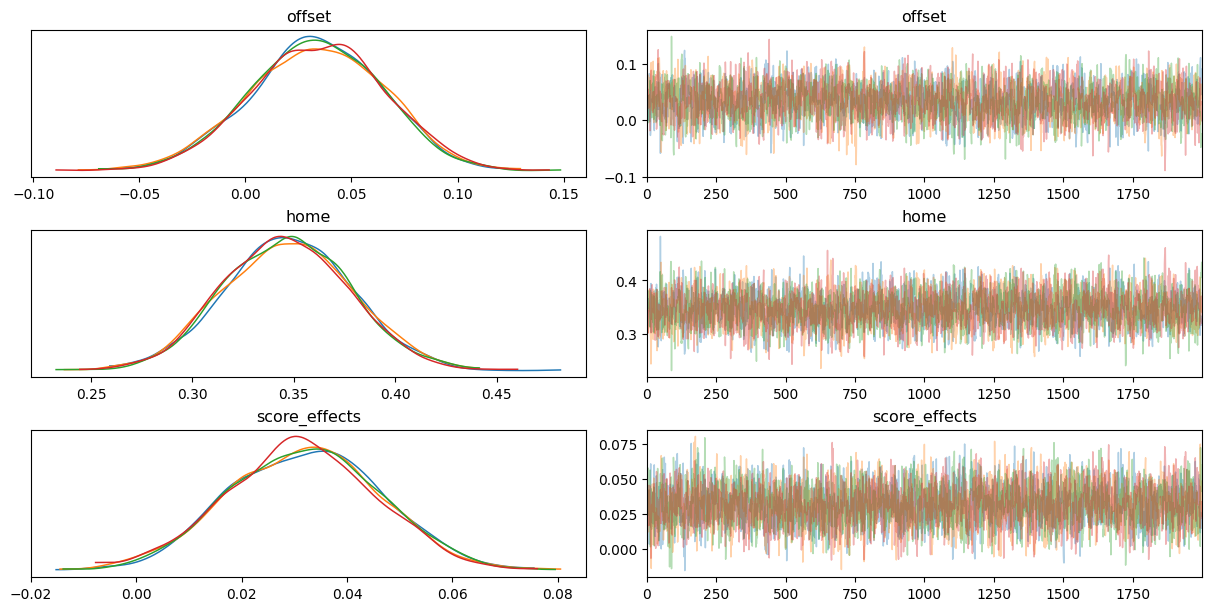

In [25]:
az.plot_trace(trace2,var_names= ['offset','home','score_effects'], compact=False);


*  Evidently score effects is significant



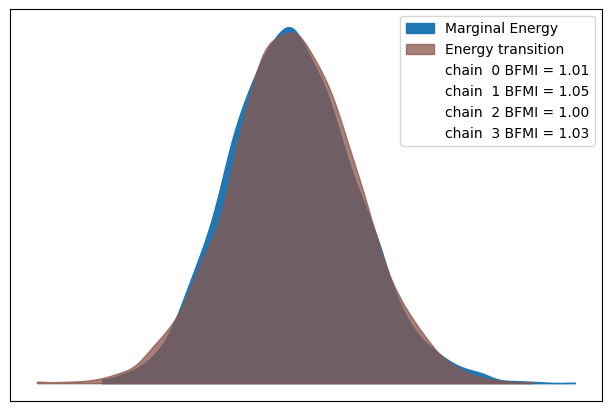

In [26]:
az.plot_energy(trace2, figsize=(6, 4));

In [27]:
pcc2 = pm.sample_posterior_predictive(trace2, model = model2)

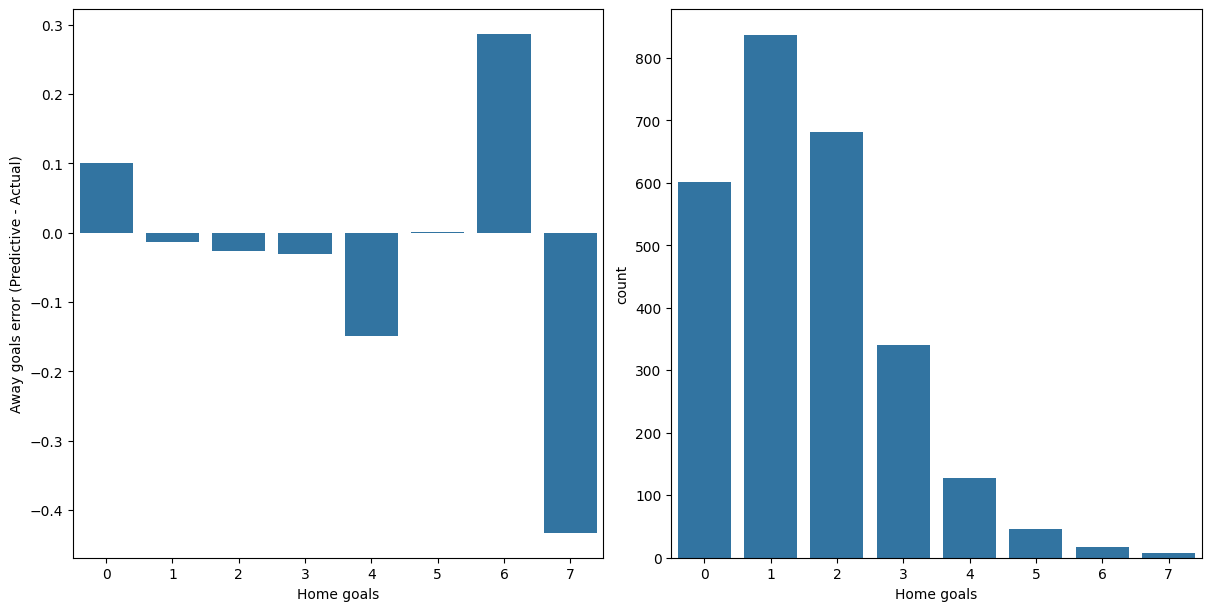

In [28]:
plot_error(pcc2)



*  Unfortunately the effects are limited and did not solve the problem in a significant way.
* This is either due to an averaging effect or incorrect assumptions
* Could attempt to create specific scoring effects for each home goal number as opposed to the linear relationship, however overfitting is expected.



# 3rd Model



* To increase accuracy on the test set we can introduce weights into the model
* The intuition is that football results from recent years are going to be much better predictors than those played a while ago.
* To capture this we can apply an exponential weighting on the data depending on the season the games were played



In [29]:
def create_model3(data):

  data['year'] = data['season'].apply(lambda x : int(x[:4]))
  data['year_weight'] = (data['year'] - (data['year'].min() -1))
  data['year_weight'] *= data['year_weight']

  with pm.Model(coords=coords) as model:

      model.add_coord("match", np.arange(len(data)), mutable=True)
      home_team = pm.MutableData("home_team", home_idx, dims="match")
      away_team = pm.MutableData("away_team", away_idx, dims="match")

      offset = pm.Normal('offset', 0.25, 0.25)
      home = pm.Normal('home', 0.25, 0.25)

      att_star = pm.Normal('att_star', mu=0, sigma=0.5, dims='team')
      def_star = pm.Normal('def_star', mu=0, sigma=0.5, dims='team')

      attack = pm.Deterministic("attack", att_star - pt.mean(att_star), dims="team")
      defence = pm.Deterministic("defence", def_star - pt.mean(def_star), dims="team")

      home_theta = pt.exp(offset + home + attack[home_team] - defence[away_team])
      away_theta = pt.exp(offset + attack[away_team] - defence[home_team])

      home_goals = pm.Poisson("home_goals", mu=home_theta, observed=data["home_team_goal"].values, dims='match')
      away_goals = pm.Poisson("away_goals", mu=away_theta, observed=data["away_team_goal"].values, dims='match')

      home_logp = pm.logp(pm.Poisson.dist(mu=home_theta), data["home_team_goal"].values)
      away_logp = pm.logp(pm.Poisson.dist(mu=away_theta), data["away_team_goal"].values)

      weighted_home_logp = data['year_weight'].values * home_logp
      weighted_away_logp = data['year_weight'].values * away_logp

      total_weighted_logp = pm.math.sum(weighted_home_logp + weighted_away_logp)
      obs = pm.Potential('obs', total_weighted_logp)

      trace = pm.sample(2000, tune=2000, chains=4, random_seed = 64)

      return trace, model

In [30]:
trace3, model3 = create_model3(pl_match_data_train)

<ipython-input-29-0f79a1de6387>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['season'].apply(lambda x : int(x[:4]))
<ipython-input-29-0f79a1de6387>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_weight'] = (data['year'] - (data['year'].min() -1))
<ipython-input-29-0f79a1de6387>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

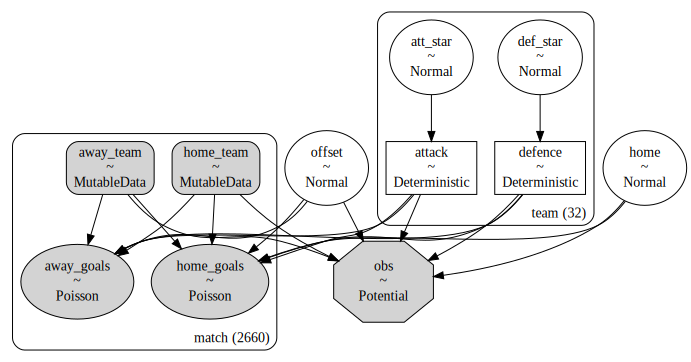

In [31]:
pm.model_to_graphviz(model3)

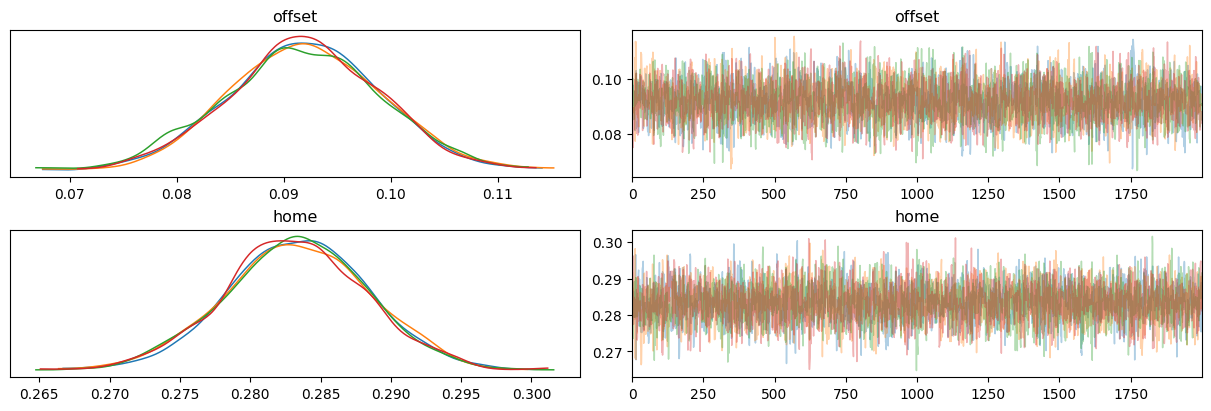

In [32]:
az.plot_trace(trace3,var_names= ['offset','home'], compact=False);

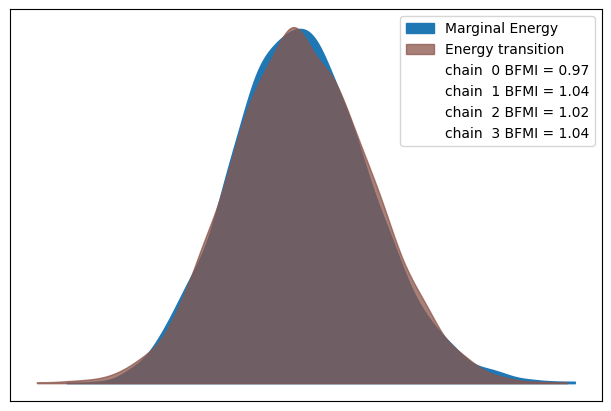

In [33]:
az.plot_energy(trace3, figsize=(6, 4));

<ipython-input-12-4ef84b1019f1>:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


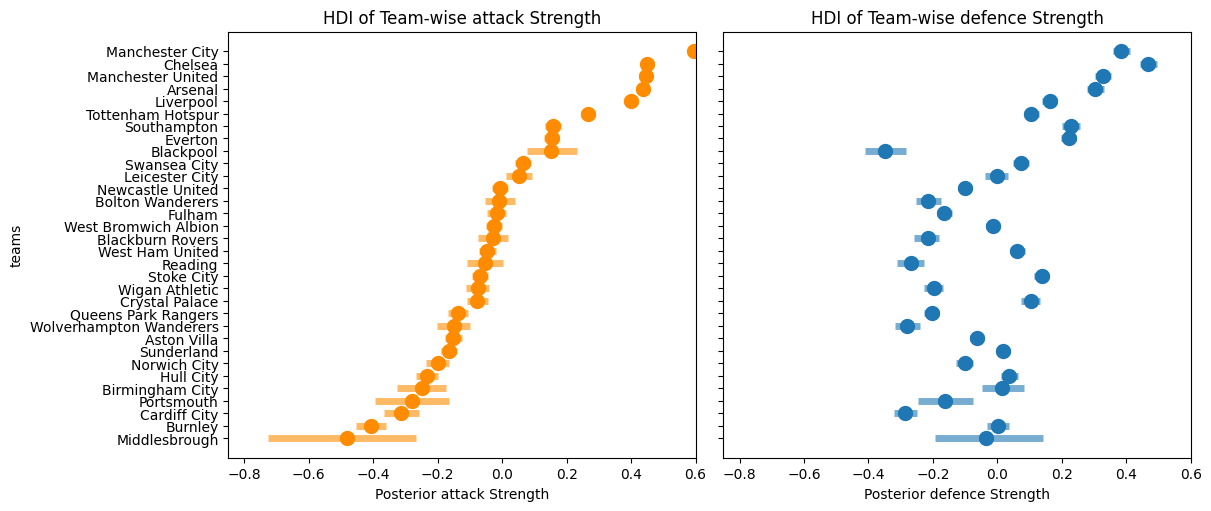

In [34]:
plot_team_values(trace3)

* The model is much more confident in assigning values for attack and defence than without different weightings
* This is likely due to higher consistency in teams across recent periods


In [36]:
train_acc_df3 = predictions(pl_match_data_train, trace3, model3, home_idx, away_idx)
train_acc_df3.iloc[:,-2:].mean()

<ipython-input-19-c4330060b656>:22: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pred = pm.sample_posterior_predictive(trace, var_names=["home_goals", "away_goals"], predictions = 'True').predictions


prob_based_acc     0.424732
model_based_acc    0.533835
dtype: float64

In [37]:
test_acc_df3 = predictions(pl_match_data_test, trace3, model3, home_idx_test, away_idx_test)
test_acc_df3.iloc[:,-2:].mean()

<ipython-input-19-c4330060b656>:22: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pred = pm.sample_posterior_predictive(trace, var_names=["home_goals", "away_goals"], predictions = 'True').predictions


prob_based_acc     0.380197
model_based_acc    0.441176
dtype: float64

* Marginal increase in accuracy on the test set
* Evidently, weighting recent seasons improves accuracy of future predictions although not as much as expected




# Predictions

In [38]:
def predict_score(trace, model, home_t, away_t):

  h_idx = np.where(teams == home_t)[0][0]
  a_idx = np.where(teams == away_t)[0][0]

  with model:

    pm.set_data({"home_team": [h_idx]*10, "away_team": [a_idx]*10},  coords = {"team": teams, 'match':np.arange(10)})

    pred = pm.sample_posterior_predictive(trace, var_names=["home_goals", "away_goals"], predictions = 'True').predictions

  away_pred = pred['away_goals'].values.flatten()
  home_pred = pred['home_goals'].values.flatten()

  combined_data = pd.DataFrame({"Home": home_pred, "Away": away_pred})
  sns.histplot(data=combined_data, multiple="dodge", stat="probability", discrete=True, shrink=.8)

  plt.xlabel("Goals")
  plt.ylabel("Density")
  plt.legend(title="Outcome", labels=[away_t + " (Away)",home_t + " (Home)"])

  plt.gca().set_yticklabels([str(round(float(tick) * 2, 2)) for tick in plt.gca().get_yticks()])

  plt.show()

  print(home_t + ' Wins - ' + str(round((home_pred > away_pred).mean()*100,2)) + '%')
  print(away_t + ' Wins - ' + str(round((home_pred < away_pred).mean()*100,2)) + '%')
  print('Draw - ' + str(round((home_pred == away_pred).mean()*100,2)) + '%')


<ipython-input-38-422e411a589e>:10: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pred = pm.sample_posterior_predictive(trace, var_names=["home_goals", "away_goals"], predictions = 'True').predictions


<ipython-input-38-422e411a589e>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([str(round(float(tick) * 2, 2)) for tick in plt.gca().get_yticks()])


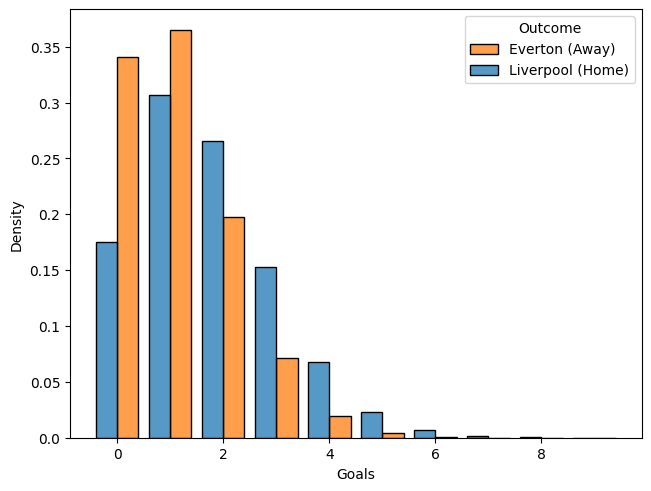

Liverpool Wins - 52.78%
Everton Wins - 23.64%
Draw - 23.58%


In [39]:
predict_score(trace3, model3, 'Liverpool', 'Everton')